<a href="https://colab.research.google.com/github/ParthikB/Vohoo-Tensorflow/blob/master/flowers_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import tensorflow_hub as hub
tf.enable_eager_execution()

import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import shutil

## Importing Data

In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, extract=True, fname='flower_photos.tgz')

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [65]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [66]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

total_train = 0
total_val   = 0

for class_ in classes:
  total_train += len(os.listdir(os.path.join(train_dir, class_)))
  total_val   += len(os.listdir(os.path.join(val_dir, class_)))
  
print("Total Training samples   :", total_train)
print("Total Validation samples :", total_val)

Total Training samples   : 2935
Total Validation samples : 735


## Data preprocessing

In [84]:
IMG_SHAPE = 224
BATCH_SIZE = 32

image_gen  = ImageDataGenerator(rescale=1./255,
                                height_shift_range=0.2,
                                width_shift_range=0.2,
                                zoom_range=0.2,
                                shear_range=0.2,
                                horizontal_flip=True,
                                rotation_range=40,
                                fill_mode='nearest')

train_data = image_gen.flow_from_directory(directory=train_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                           class_mode='binary')

image_gen  = ImageDataGenerator(rescale=1./255)

val_data   = image_gen.flow_from_directory(directory=val_dir,
                                           batch_size=BATCH_SIZE,
                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                           class_mode='binary')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


## Model Importing
------- MobileNet -------

In [0]:
mobile_net_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2",
                                  input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

mobile_net_layer.trainable = False

## Model Structure

In [86]:
model = tf.keras.Sequential([
    mobile_net_layer,
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

## Model Training

In [88]:
EPOCHS = 10

history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data = val_data)

Epoch 1/10
92/92 [==============================] - 54s 590ms/step - loss: 0.8150 - acc: 0.6954 - val_loss: 0.4676 - val_acc: 0.8490
Epoch 2/10
92/92 [==============================] - 49s 529ms/step - loss: 0.4553 - acc: 0.8429 - val_loss: 0.3553 - val_acc: 0.8925
Epoch 3/10
92/92 [==============================] - 49s 528ms/step - loss: 0.4032 - acc: 0.8583 - val_loss: 0.3255 - val_acc: 0.8966
Epoch 4/10
92/92 [==============================] - 49s 530ms/step - loss: 0.3400 - acc: 0.8739 - val_loss: 0.3165 - val_acc: 0.9020
Epoch 5/10
92/92 [==============================] - 49s 533ms/step - loss: 0.3289 - acc: 0.8811 - val_loss: 0.3221 - val_acc: 0.8857
Epoch 6/10
92/92 [==============================] - 49s 529ms/step - loss: 0.3066 - acc: 0.8930 - val_loss: 0.2932 - val_acc: 0.9020
Epoch 7/10
92/92 [==============================] - 49s 528ms/step - loss: 0.2964 - acc: 0.8903 - val_loss: 0.3017 - val_acc: 0.8993
Epoch 8/10
92/92 [==============================] - 49s 533ms/step - 

## Results Visualization

Text(0, 0.5, 'Loss')

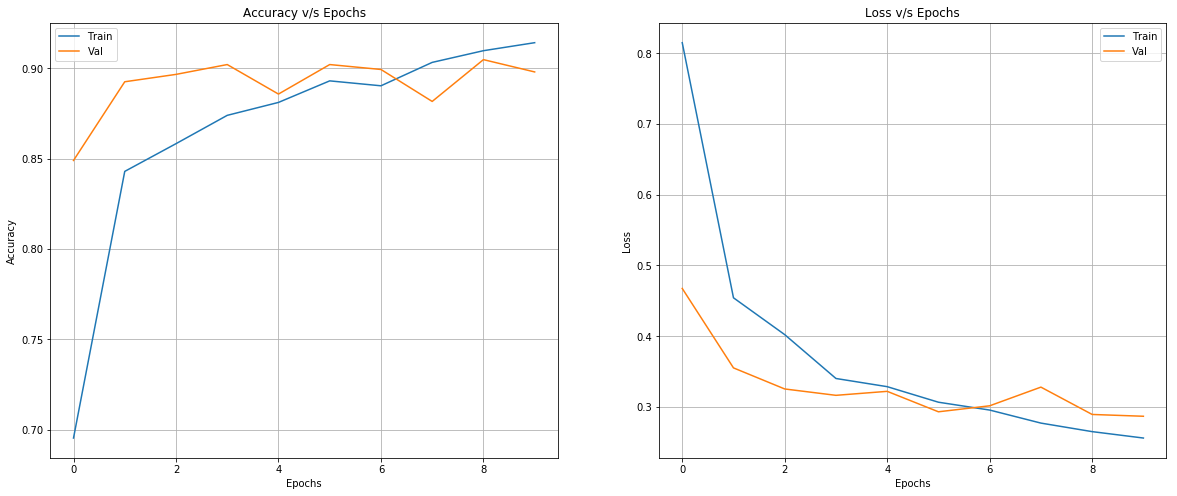

In [93]:
train_acc  = history.history['acc']
train_loss = history.history['loss']

val_acc    = history.history['val_acc']
val_loss   = history.history['val_loss']

epochs     = list(range(10))

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train')
plt.plot(epochs, val_acc, label='Val')
plt.legend()
plt.grid(1)
plt.title("Accuracy v/s Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train')
plt.plot(epochs, val_loss, label='Val')
plt.legend()
plt.grid(1)
plt.title("Loss v/s Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')